In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
import os, time, sys, random
import torch
import random
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
#data_path = "drive/My Drive/Simple_Chest_XRay/"
#data_path = "drive/My Drive/NIH_Chest_XRay/"
data_path = "drive/My Drive/Harvard_Chest_XRay/"

sample_ratio = 0.4
batch_size = 64
num_epochs = 10

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

**DATA PREPROCESSING**


In [ ]:
%run "/content/drive/My Drive/Colab Notebooks/utils.ipynb"
dataset, train_loader, train_indices, test_loader, test_indices, val_loader, val_indices = data_preprocess(data_path, sample_ratio)

 **DOWNLOAD RESNET18 MODEL AND TRAIN**


In [ ]:
def save_metrics(loss, accuracy):
  np.save("{}train_loss.npy".format(data_path), loss)
  np.save("{}train_accuracy.npy".format(data_path), accuracy)

In [ ]:
# Define the ResNet18 model and set Pretraining to False to train model from scratch
model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained = False)
model.fc = nn.Linear(512, len(dataset.classes))

# Define loss function as CrossEntropy and optimizer as Adam Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
losses, accuracies = [], []

# Train model on training set
for epoch in range(num_epochs):
    train_loss, train_accuracy, start_time = 0.0, 0.0, time.time()

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        train_accuracy += torch.sum(preds == labels.data)

    train_loss /= len(train_indices)
    train_accuracy /= len(train_indices)
    losses.append(train_loss)
    accuracies.append(train_accuracy.item())
    
    print(losses, accuracies)
    print('Epoch: {} | Training Accuracy: {:.4f} | Training Loss: {:.4f} | Time: {:.4f}s'.format(epoch+1, train_accuracy, train_loss, time.time() - start_time))
save_metrics(losses, accuracies)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


[1.137255515717194] [0.5487924814224243]
Epoch: 1 | Training Accuracy: 0.5488 | Training Loss: 1.1373 | Time: 2399.1090s
[1.137255515717194, 0.9117305073278509] [0.5487924814224243, 0.6503114700317383]
Epoch: 2 | Training Accuracy: 0.6503 | Training Loss: 0.9117 | Time: 1786.4250s
[1.137255515717194, 0.9117305073278509, 0.7489881453234281] [0.5487924814224243, 0.6503114700317383, 0.7197027802467346]
Epoch: 3 | Training Accuracy: 0.7197 | Training Loss: 0.7490 | Time: 1804.6012s
[1.137255515717194, 0.9117305073278509, 0.7489881453234281, 0.6488043796415603] [0.5487924814224243, 0.6503114700317383, 0.7197027802467346, 0.759479820728302]
Epoch: 4 | Training Accuracy: 0.7595 | Training Loss: 0.6488 | Time: 1758.9242s
[1.137255515717194, 0.9117305073278509, 0.7489881453234281, 0.6488043796415603, 0.5791921593975908] [0.5487924814224243, 0.6503114700317383, 0.7197027802467346, 0.759479820728302, 0.784832239151001]
Epoch: 5 | Training Accuracy: 0.7848 | Training Loss: 0.5792 | Time: 1751.9350

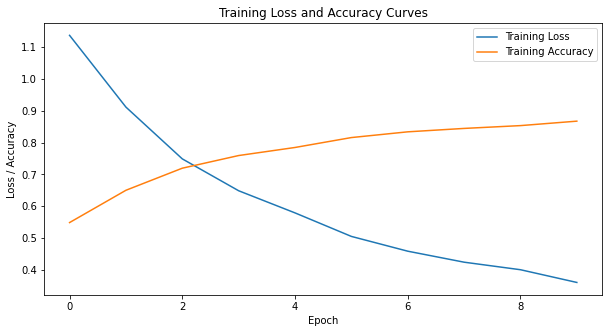

In [ ]:
#Plotting the Loss and Accuracy Curves
plt.figure(figsize = (10, 5))
plt.plot(losses, label = 'Training Loss')
plt.plot(accuracies, label = 'Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.title('Training Loss and Accuracy Curves')
plt.legend()
plt.show()

**EVALUATE MODEL ON VALIDATION AND TEST SET**

In [ ]:
#Evaluate Model on Test Set
evaluate_model(model, test_loader, test_indices, 'TEST', criterion, data_path, "ResNet18")

#Evaluate Model on Validation Set
evaluate_model(model, val_loader, val_indices, 'VALIDATION', criterion, data_path, "ResNet18")

**SAVE MODEL PARAMETERS**

In [ ]:
torch.save(model.state_dict(), "{}resnet18.pth".format(data_path))